# Preprocessing of Antibody capture single cell data
Additionally to capturing only transcriptomic data with single cell analyses, we are now able to also capture the abundance of surface protein expression additionally CITE{}cite{https://www.nature.com/articles/nmeth.4380}.
This additional modality requires different preprocessing compared to what we described in section \link{preprocessing} as data distributions are different. In the following, we will guide you through preprocessing ADT data.
## Introduction
By using barcode tagged antibodies, it is possible to first bind the antibodies to the cells and later sequence the barcodes together with the RNA

![CITE-Seq not sure if we can use this?](https://citeseq.files.wordpress.com/2017/10/antibody_transparent.png)

This allows us to identify cell types based on conventional markers from flow cytometry experiments which is especially useful for specific immune cell populations.
Contrary to the negative binomial distribution of UMI counts, ADT data follows a different distribution. The data is noisier, as unbound antibodies lead to counts in cells or empty droplets where the protein is not present.

Due to this different approaches for quality control and normalisation are needed. Furthermore, the data contains fewer features as antibody panels are limited to up to 100 features, contrary to around 20.000 features in the gene expression space.

## Importing the data
In this tutorial, we will use scanpy and muon to analyse the data.

In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import glob

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the data
We're reading in the data with muon, this way we already have two subobjects, one for RNA and ADT counts each

To get the file paths for the individual samples, we use glob with a regular expression.

We read in the filtered objects, in which cell calling by Cellranger is already performed as well as the unfiltered objects.

In [2]:
filtered_files = glob.glob('/Users/daniel.strobl/extended-single-cell-best-practices/neurips/s*d*/filtered_*/')

In [3]:
raw_files = glob.glob('/Users/daniel.strobl/extended-single-cell-best-practices/neurips/s*d*/raw_*/')

As mudata does not support concatenation, we need to use the scanpy function for this. We split each object into a GEX and an ADT anndata object,
concatenate those individually and finally attach them to a new, joint MuData object.
We do this for both the filtered and the raw object.

In [4]:
filtered_mu = {}
for i in filtered_files:
    name = i.split('/')[5]
    filtered_mu[name]=mu.read_10x_mtx(i)
    filtered_mu[name]['prot'].obs['donor']=name
    filtered_mu[name]['rna'].obs['donor']=name
    
filtered = filtered_mu.pop('s1d1')
filtered_rna = filtered['rna']
filtered_prot = filtered['prot']
for i in filtered_mu.keys():
    filtered_rna = filtered_rna.concatenate(filtered_mu[i]['rna'])
    filtered_prot = filtered_prot.concatenate(filtered_mu[i]['prot'])
filtered = mu.MuData({'rna':filtered_rna, 'prot': filtered_prot})
del filtered_mu

In [5]:
raw_mu = {}
for i in raw_files:
    name = i.split('/')[5]
    raw_mu[name]=mu.read_10x_mtx(i)
    raw_mu[name]['prot'].obs['donor']=name
    raw_mu[name]['rna'].obs['donor']=name
    
raw = raw_mu.pop('s1d1')
raw_rna = raw['rna']
raw_prot = raw['prot']
for i in raw_mu.keys():
    raw_rna = raw_rna.concatenate(raw_mu[i]['rna'])
    raw_prot = raw_prot.concatenate(raw_mu[i]['prot'])
raw = mu.MuData({'rna':raw_rna, 'prot': raw_prot})
del raw_mu

Now, we have two Mudata objects, the filtered one contains 122016 cells while the unfiltered one contains
over two million observations.

In [6]:
filtered

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

In [7]:
raw

MuData object with n_obs × n_vars = 24807643 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	24807643 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	24807643 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

## QC of the data
Similar to the qc and filtering of RNA data, we also need to preprocess ADT data. Empty droplets still contain reads for ADT counts, as unbound antibodies are sequenced. We can, however make use of these empty droplets to normalise our count data as we can consider this as the ambient background level for each antibody.

In [8]:
filtered['prot'].X

<122016x140 sparse matrix of type '<class 'numpy.float32'>'
	with 14267923 stored elements in Compressed Sparse Row format>

In [9]:
sc.pp.calculate_qc_metrics(filtered['prot'], inplace=True, percent_top=None)

In [10]:
sc.pp.calculate_qc_metrics(raw['prot'], inplace=True, percent_top=None)

In [11]:
import seaborn as sns

We first look at the distribution of number of ADTs per cell over all samples. We plot this using the seaborn library.

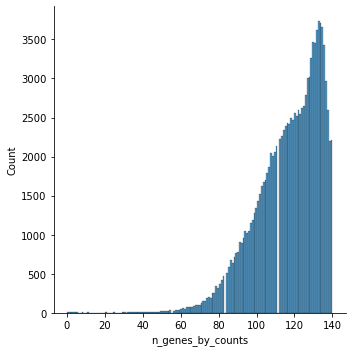

In [12]:
sns.displot(filtered['prot'].obs.n_genes_by_counts)

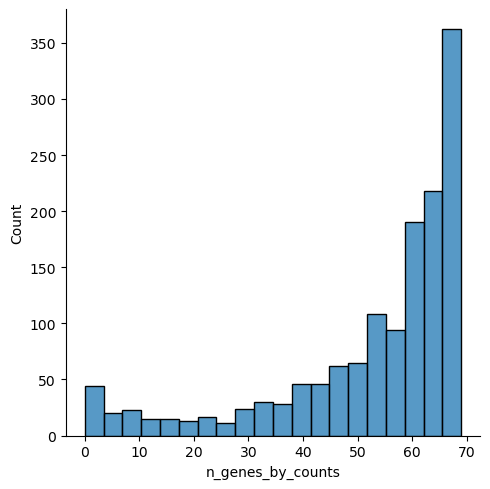

In [13]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts<70].obs.n_genes_by_counts)

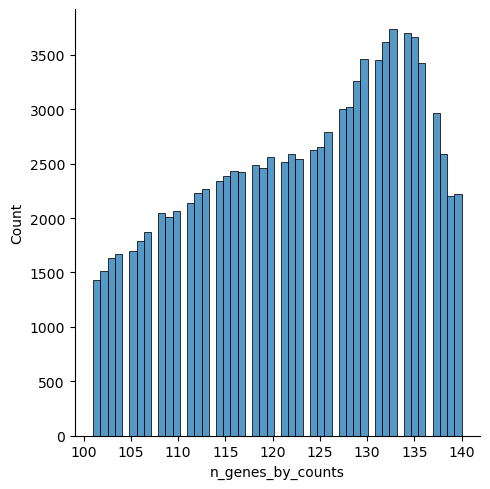

In [14]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts>100].obs.n_genes_by_counts)

We can see a 'valley' in the distribution at around 55 genes, so we decide to set the cutoff here.

Next, we do the same thing based on total counts per cell.

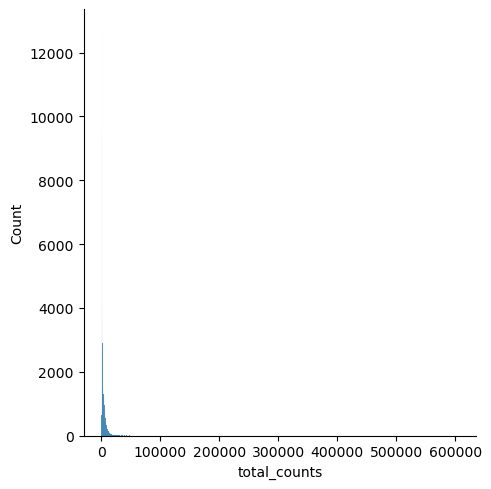

In [15]:
sns.displot(filtered['prot'].obs.total_counts)

We zoom in to see the upper end of the distribution for the total counts to decide on a cutoff for the maximum number of counts.

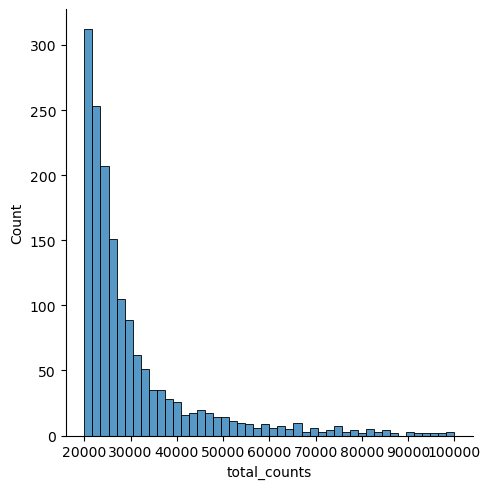

In [16]:
sns.displot(filtered['prot'].obs.query('total_counts>20000 and total_counts<100000').total_counts)

### Sample-wise QC
Next, we look at the distribution of counts per cell across the samples to see if there are differences.

In [17]:
sc.pp.filter_cells(filtered['prot'], max_counts=100000)

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

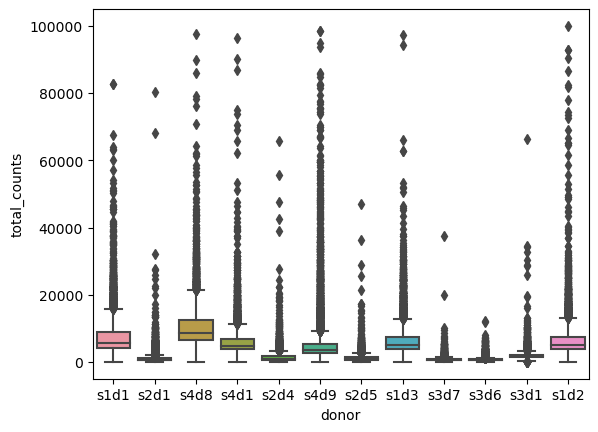

In [18]:
sns.boxplot(y=filtered['prot'].obs.total_counts, x=filtered['prot'].obs['donor'])

The distributions of counts are different for the diffent samples. Thus, we decide to do sample-wise QC.

As we have a large number of samples, we do sample-wise QC automatically based on the process described in the RNA preprocessing chapter.

In [19]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (np.median(M) + nmads * M.mad() < M)
    return outlier

In [20]:
outliers = []
for sample in np.unique(filtered['prot'].obs['donor']):
    adata_temp = filtered['prot'][filtered['prot'].obs['donor'] == sample].copy()
    adata_temp.obs['outlier'] = is_outlier(adata_temp, 'log1p_total_counts', 5) | is_outlier(adata_temp, 'log1p_n_genes_by_counts', 5)
    outliers.append(adata_temp.obs['outlier'])
    print(
        f"{sample}: outliers {adata_temp.obs.outlier.value_counts()[True]}"
    )

s1d1: outliers 116
s1d2: outliers 103
s1d3: outliers 100
s2d1: outliers 132
s2d4: outliers 102
s2d5: outliers 104
s3d1: outliers 180
s3d6: outliers 206
s3d7: outliers 177
s4d1: outliers 81
s4d8: outliers 41
s4d9: outliers 137


In [21]:
filtered['prot'].obs['outliers'] = pd.concat(outliers)

In [22]:
filtered['prot'].obs

,donor,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,outliers
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,124,4.828314,6483.0,8.777093,6483.0,False
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,140,4.948760,19711.0,9.888983,19711.0,False
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,120,4.795791,3349.0,8.116715,3349.0,False
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,128,4.859812,7841.0,8.967249,7841.0,False
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,114,4.744932,2462.0,7.809135,2462.0,False
...,...,...,...,...,...,...,...,...
TTTGTTGAGGTCCCGT-1-1,s1d2,1,128,4.859812,6469.0,8.774931,6469.0,False
TTTGTTGGTAGGTCAG-1-1,s1d2,1,124,4.828314,5340.0,8.583168,5340.0,False
TTTGTTGGTGTTCAGT-1-1,s1d2,1,119,4.787492,3619.0,8.194229,3619.0,False
TTTGTTGGTTCGAGCC-1-1,s1d2,1,116,4.762174,3283.0,8.096817,3283.0,False


In [27]:
filtered.update()

In [28]:
filtered = filtered[filtered.obs.loc[filtered['prot'].obs_names].index]

In [29]:
filtered = filtered[filtered['prot'].obs['outliers']==False]

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

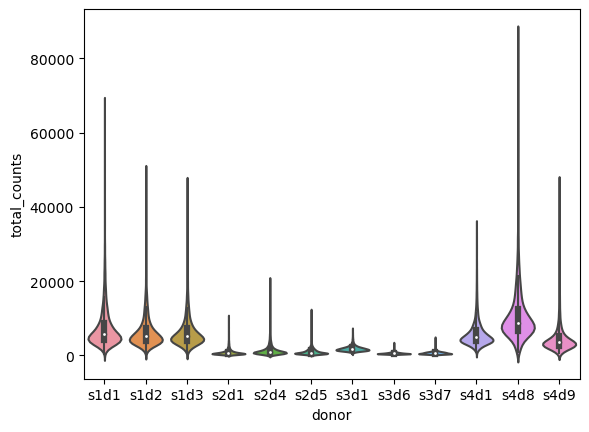

In [42]:
sns.violinplot(y=filtered['prot'].obs.total_counts, x=filtered['prot'].obs['donor'], scale='width')

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='total_counts'>

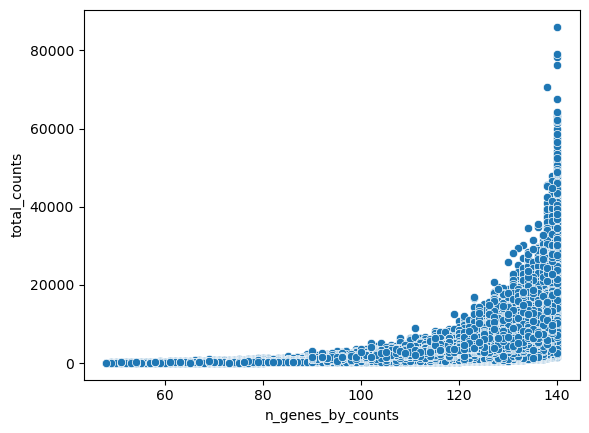

In [31]:
sns.scatterplot(filtered['prot'].obs.n_genes_by_counts, filtered['prot'].obs.total_counts)

In [32]:
filtered

View of MuData object with n_obs × n_vars = 120502 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalisation
Next, we're normalising the data. As we have the raw data available, we can use the background distribution to normalise against.
Here, we also have isotype controls available, meaning antibodies that bind nonspecifically to the cells, thus giving us a background to compare against.
We're calling the normalisation function `mu.prot.pp.dsb` with the filtered and raw mudata object as well as the names of the isotype controls.

In [33]:
isotype_controls = ['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b']

In [34]:
filtered['prot'].layers['counts'] = filtered['prot'].X

In [35]:
mu.prot.pp.dsb(filtered, raw, isotype_controls=isotype_controls)

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/muon/_prot/preproc.py:109: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  warn(


If you don't have the unfiltered data available, you can also normalise the ADT data with `mu.prot.pp.clr`, a centered log-ratio normalisation.

## Dimensionality reduction and visualisation

Next, we reduce the dimensionality of the data with PCA, compute a neighborhood graph and a UMAP emdedding to visualise the study.

In [36]:
sc.pp.pca(filtered['prot'], svd_solver='arpack')

In [37]:
sc.pp.neighbors(filtered['prot'])

In [38]:
sc.tl.umap(filtered['prot'])

In [39]:
filtered['prot'].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b',
       'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5-1', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L', 'CD161'],
      dtype='object')

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


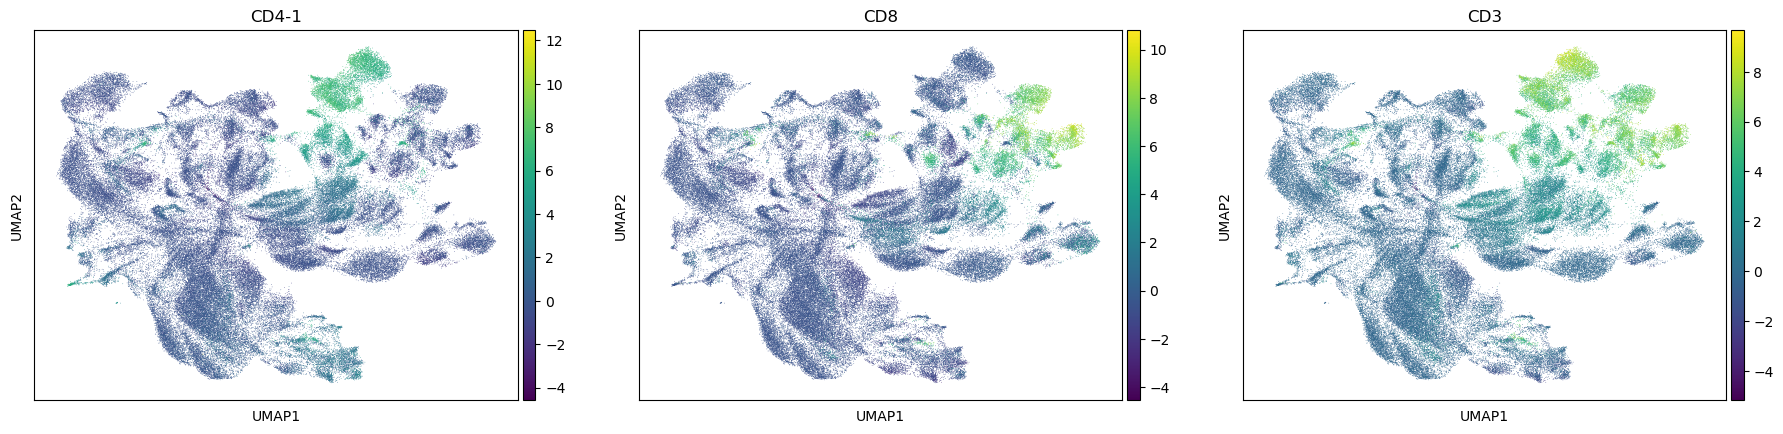

In [40]:
sc.pl.umap(filtered['prot'], color=['CD4-1', 'CD8', 'CD3'])

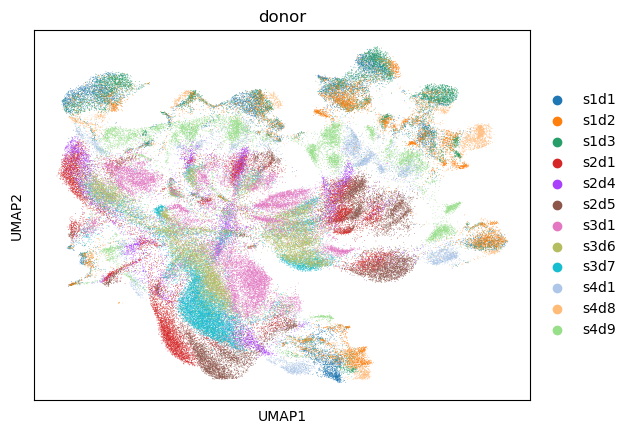

In [41]:
sc.pl.umap(filtered['prot'], color='donor')

As it can be seen in the above UMAP representation, different samples cluster apart from each other for similar populations (See CD4 and CD8 expression in the previous plot). Thus, batch correction of the data would be necessary.
Here, we use harmony to perform batch correction of the data.